# Modelo de FitzHugh–Nagumo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Método Runge-Kutta ###

Este método consiste en plantear una fórmula de cuadratura de tipo interpolatorio general para resolver la integral de $f(x, y(x))$, sobre los nodos $x_i \leq \xi_0 \leq ... \leq \xi_n \leq x_{i+1}$. Esta aproximación requiere del conocimiento de la solución sobre los nodos $\xi_\mu$, a priori desconocida, por lo que es necesario diseñar una forma de aproximarlas de modo que se plantea $\eta_\mu \approx y(\xi_\mu)$. Sin entrar en detalles del procedimiento, se define el método
\begin{equation}
y_{i+1} = y_i + h\sum_{\mu = 0}^n \alpha_\mu f(\xi_\mu, \eta_\mu)
\end{equation}

Este tipo de método son los conocidos como métodos Runge-Kutta. En concreto, se planteará un método Runge-Kutta de cuarto orden, que surge como una variante propuesta por Runge a los métodos Kutta y recibe el nombre de método Runge-Kutta. El esquema computacional del mismo es el siguiente

\begin{align}
K_1 &= f(x_i, y_i) \\
K_2 &= f\left(x_i + \frac{h}{2}, y_i + \frac{h}{2}K_1\right) \\
K_3 &= f\left(x_i + \frac{h}{2}, y_i + \frac{h}{2}K_2\right) \\
K_4 &= f\left(x_i + h, y_i + hK_3\right) \\
y_{i+1} &= y_i + \frac{h}{6}(K_1 + 2K_2 + 2K_3 + K_4)
\end{align}

In [ ]:
def rungekuta(x_i, y_i, f, h):
  k1 = f(x_i, y_i)
  k2 = f(x_i + h/2, y_i + h/2*k1)
  k3 = f(x_i + h/2, y_i + h/2*k2)
  k4 = f(x_i + h, y_i + h*k3)
  return y_i + h/6*(k1 + 2*k2 + 2*k3 + k4)

Este método se puede mejorar de una forma muy sencilla. Para ello, se usan los valores obtenidos tras aplicar el método con un paso $h$ (los denotaremos por $y_{i+1,1}$) y con un paso $h/2$ (los denotaremos por $y_{i+1,2})$. Como en el último caso habrá el doble de valores y solo nos interesan los valores calculados en los puntos $x_i$, calculados como $x_{i+1} = x_i + h$, se eliminarán del array los valores no deseados y se obtiene como mejora los siguientes valores
\begin{equation}
y(x_{i+1}) \approx \frac{2^my_{i+1,2} - y_{i+1,1}}{2^m - 1}
\end{equation}
con m el orden del método (4 en este caso). \\

Hay que tener en cuenta que, al eliminar elementos de dos en dos del array con los $y_{i+1, 2}$, puede darse el caso de que tenga un elemento menos que el array con los $y_{i+1, 1}$. Para corregir este posible fallo, se compararán las longitudes de ambos y si no coinciden, se eliminará el último elemento del array que contenga los $y_{i+1,1}$, así como del array que contiene los nodos $x_i$, que es de la mismo dimensión que el array justo antes mencionado. Una vez corregido esto ya se pueden calcular perfectamente los valores $y(x_{i+1})$.

In [ ]:
def rkm(x_0, x_f, y_0, integrador, f, h, metodo):
  x_paso, y_paso = integrador(x_0, x_f, y_0, f, h, metodo)
  x_mediopaso, y_mediopaso = integrador(x_0, x_f, y_0, f, h/2, metodo)
  y_mediopaso = y_mediopaso[::2,:] #cogemos los valores que nos interesan
  if (len(y_mediopaso[:,0]) == len(y_paso[:,0])):
    y_mejorado = (y_paso - y_mediopaso*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  else:
    y_paso = np.delete(y_paso, -1, 0)
    x_paso = np.delete(x_paso, -1)
    y_mejorado = (y_paso - y_mediopaso*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  return x_paso, y_mejorado

### Integrador ###

A continuación se definirá una función que aplicará el método anterior a la resolución del problema a plantear. \\

El método de Runge-Kutta es un método de un paso, así que usaremos la función $\textit{integrador1p}$. Esta requiere los valores inicial y final de los nodos $x_i$ y el paso h, así como el problema planteado $f$ y el método a aplicar (en este caso el Runge-Kutta). Para un caso general hay que tener en cuenta que $y$ será una matriz (caso de dos o más EDOs), mientras que $x$ será siempre un array unidimensional.

In [ ]:
def integrador1p(x0, xf, y0, f, h, metodo):
  #define x e y
  x = np.zeros(int((xf - x0)/h))
  x[0] = x0
  y = np.zeros((int((xf - x0)/h), len(y0)))
  y[0] = y0
  #iteramos
  for i in range(1, int((xf - x0)/h)):
    if x[i-1] < xf:
      y[i, :] = metodo(x[i-1], y[i-1], f, h)
      x[i] = x[i-1] + h
  return x, y

##Problema a resolver##



Es este caso queremos tratar el modelo de FitzHugh–Nagumo, paradigma de los modelos de excitabilidad que describe la dinámica de activación y desactivación de una neurona mediante el par de ecuaciones:
\begin{align}
\dot{V} &= V(a - V)(V - 1) - w + I_{\text{ext}} \\
\dot{w} &= bV - cw
\end{align}

Se define una clase para describir el modelo. En ella, a parte de las ecuaciones del modelo, meteremos las nuclinas del sistema.  

In [ ]:
class ecs:
  """
  Aquí se define el modelo de FitzHugh–Nagumo, paradigma de los modelos de
  excitabilidad que describe la dinámica de activación y desactivación de una
  neurona mediante dos ecuaciones diferenciales de primer orden acopladas.
  Por defecto se tomarán los valores:
  a = 0.1
  b = 1
  c = 0.033
  iext = 0
  Dentro de esta clase también se definirán las nulclinas del sistema.
  """
  def __init__(self, a = 0.1, b = 1, c = 0.033, iext = 0):
    self.a = a
    self.b = b
    self.c = c
    self.iext = iext

  def __call__(self, v, w):
    vdot = w[0]*(self.a - w[0])*(w[0] - 1) - w[1] + self.iext
    wdot = self.b*w[0] - self.c*w[1]
    return np.array([vdot, wdot])

  def get_vdot(self, v, w):
    return v*(self.a - v)*(v - 1) - w + self.iext

  def get_wdot(self, v, w):
      return self.b*v - self.c*w

  def get_nulc1(self, v):
    return v*(self.a - v)*(v - 1) + self.iext

  def get_nucl2(self, v):
    return self.b*v/self.c

  def get_b(self):
    return self.b

  def get_iext(self):
    return self.iext

Por simplificar un poco más y aligerar el futuro código, también se definirá una función para pintar el campo vectorial asociado al modelo

In [ ]:
def vfield(x_0, x_f, y_0, y_f, num_puntos, clase):
  #región donde graficar el campo vectorial
  x_range = np.linspace(x_0, x_f, num_puntos)
  y_range = np.linspace(y_0, y_f, num_puntos)

  #cuadrícula con coordenadas de cada punto en la región
  x, y = np.meshgrid(x_range, y_range)

  #valor derivadas en c/punto de la cuadrícula
  dx = clase.get_vdot(x, y)
  dy = clase.get_wdot(x, y)
  return x, y, dx, dy

Con todo bien definido ya solo queda pintar lo que queremos. En este caso, se pintarán en una gráfica las nulcinas, el campo vectorial y una trayectoria ($w$ frente a $V$), y en otras justo debajo de esta, la trayectoria $V$ frente al tiempo y $w$ frente al tiempo. Todo esto para 3 valores distintos de $b$; uno cuando solo exista un punto de corte entre las nuclinas, otro en el caso límite y otro cuando exista más de un punto de corte bien definido. Primero sacamos todos los datos que necesitaremos para graficar lo antes mencionado

In [ ]:
#definimos varios modelos que cambian solo en el parámetro 'b'
modelo1 = ecs(b = 0.1)
modelo2 = ecs(b = 0.0066825)
modelo3 = ecs(b = 0.006)

x_ini, x_fin, h = 0, 1000, 0.03

#se establecen las distintas condiciones iniciales como ([v_0, w_0])
y_ini1 = np.array([0, 0.075])
y_ini2 = np.array([0.2, 0])
y_ini3 = np.array([0.8, 0.05])

#trayectorias dependiendo de las condiciones iniciales y del modelo usado
x_tray1_model1, y_tray1_model1 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo1, h, rungekuta)
x_tray1_model2, y_tray1_model2 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo2, h, rungekuta)
x_tray1_model3, y_tray1_model3 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo3, h, rungekuta)

x_tray2_model1, y_tray2_model1 = rkm(x_ini, x_fin, y_ini2, integrador1p, modelo1, h, rungekuta)
x_tray2_model2, y_tray2_model2 = rkm(x_ini, x_fin, y_ini2, integrador1p, modelo2, h, rungekuta)
x_tray2_model3, y_tray2_model3 = rkm(x_ini, x_fin, y_ini2, integrador1p, modelo3, h, rungekuta)

x_tray3_model1, y_tray3_model1 = rkm(x_ini, x_fin, y_ini3, integrador1p, modelo1, h, rungekuta)
x_tray3_model2, y_tray3_model2 = rkm(x_ini, x_fin, y_ini3, integrador1p, modelo2, h, rungekuta)
x_tray3_model3, y_tray3_model3 = rkm(x_ini, x_fin, y_ini3, integrador1p, modelo3, h, rungekuta)

#nuclinas de cada modelo
x_nullcline = np.arange(-1, 1, 0.01)
y_nullcline1_model1 = modelo1.get_nulc1(x_nullcline)
y_nullcline2_model1 = modelo1.get_nucl2(x_nullcline)

y_nullcline1_model2 = modelo2.get_nulc1(x_nullcline)
y_nullcline2_model2 = modelo2.get_nucl2(x_nullcline)

y_nullcline1_model3 = modelo3.get_nulc1(x_nullcline)
y_nullcline2_model3 = modelo3.get_nucl2(x_nullcline)


#campo vectorial de cada modelo
x1 = vfield(-1, 1, -1, 1, 70, modelo1)[0]
y1 = vfield(-1, 1, -1, 1, 70, modelo1)[1]
dx1 = vfield(-1, 1, -1, 1, 70, modelo1)[2]
dy1 = vfield(-1, 1, -1, 1, 70, modelo1)[3]

x2 = vfield(-1, 1, -1, 1, 70, modelo2)[0]
y2 = vfield(-1, 1, -1, 1, 70, modelo2)[1]
dx2 = vfield(-1, 1, -1, 1, 70, modelo2)[2]
dy2 = vfield(-1, 1, -1, 1, 70, modelo2)[3]

x3 = vfield(-1, 1, -1, 1, 70, modelo3)[0]
y3 = vfield(-1, 1, -1, 1, 70, modelo3)[1]
dx3 = vfield(-1, 1, -1, 1, 70, modelo3)[2]
dy3 = vfield(-1, 1, -1, 1, 70, modelo3)[3]

Ahora, antes de graficar definimos una lista con distintos colores porque no estamos para hacer gráficas feas y los de matplotlib dejan un poco que desear:
* Rojo #FF0000
* Naranja #FF9B00
* Amarillo (no muy chillón) #F5DE00
* Verde clarito #51FF53
* Verde oscuro #00A902
* Azul verdoso o lo que sea esto #00FF8F
* Azul clarito #00F5E6
* Azul #00B2FF
* Azul oscuro #0032FF
* Morado #B900FF
* Violeta #8700FF
* Rosita #FF86F6
* Rosa #EA00D9
* Rosa oscuro #B00070
* Gris #A4A4A4




In [ ]:
colores = ['#FF0000', '#FF9B00', '#F5DE00', '#51FF53', '#00A902', '#00FF8F',
           '#00F5E6', '#00B2FF', '#0032FF', '#B900FF', '#8700FF', '#FF86F6',
           '#EA00D9', '#B00070', '#A4A4A4']

Con esto ya nos podemos apañar; ahora si podemos graficar los rollos

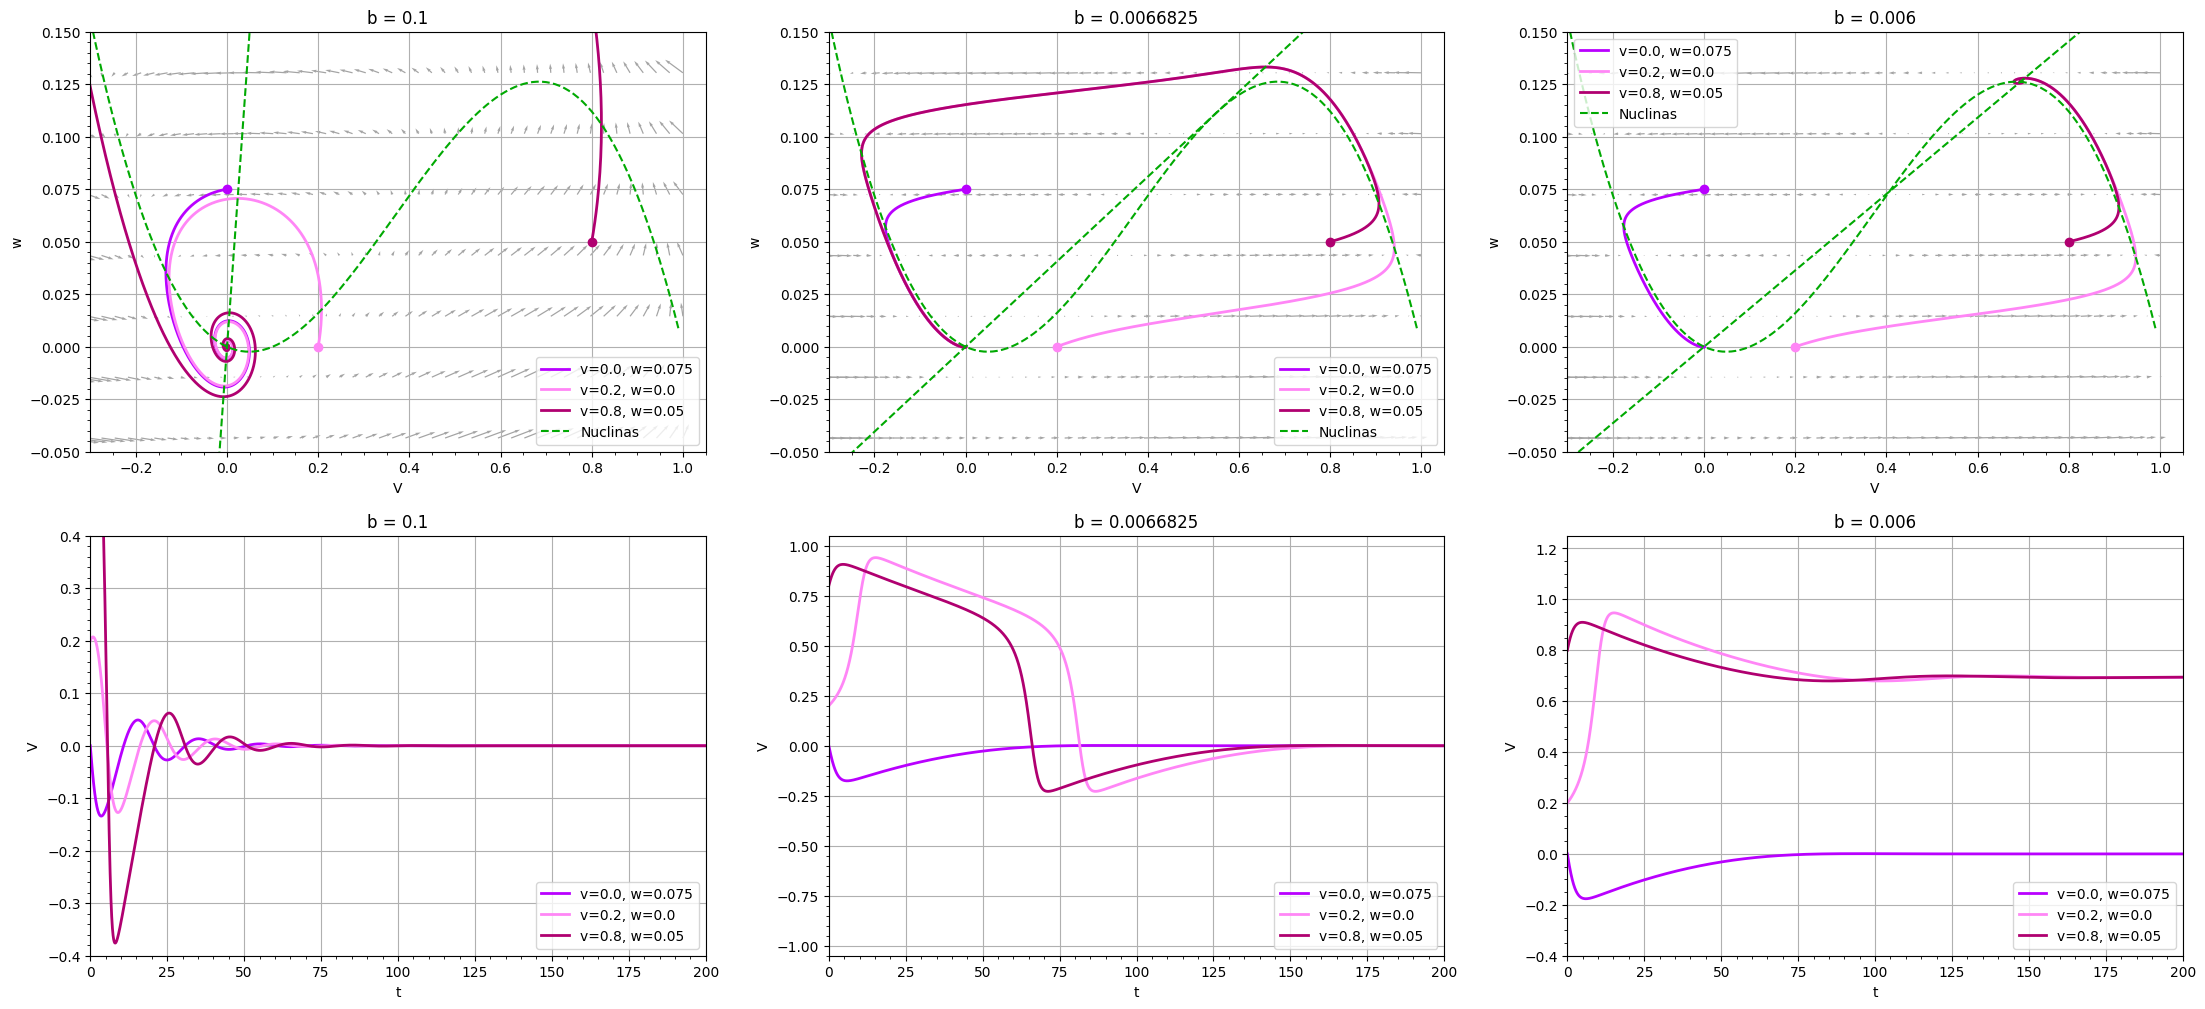

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(27, 12))

"""
pintamos tres trayectorias con distintas condiciones iniciales, así como
el punto inicial de cada una.
"""
ax[0,0].plot(y_tray1_model1[:,0], y_tray1_model1[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,0].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

ax[0,0].plot(y_tray2_model1[:,0], y_tray2_model1[:,1],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])
ax[0,0].plot(y_ini2[0], y_ini2[1], markersize=6, marker='o', color=colores[11])

ax[0,0].plot(y_tray3_model1[:,0], y_tray3_model1[:,1],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])
ax[0,0].plot(y_ini3[0], y_ini3[1], markersize=6, marker='o', color=colores[13])

#pintamos el campo vectorial
ax[0,0].quiver(x1, y1, dx1, dy1, color=colores[14], scale=4.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 4)

#pintamos las nuclinas
ax[0,0].plot(x_nullcline, y_nullcline1_model1, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[0,0].plot(x_nullcline, y_nullcline2_model1, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos bonita la gráfica
ax[0,0].set_title('b = ' + str(modelo1.get_b()))
ax[0,0].set_xlim(-0.3, 1.05)
ax[0,0].set_ylim(-0.05, 0.15)
ax[0,0].set_xlabel('V')
ax[0,0].set_ylabel('w')
ax[0,0].legend(fontsize=10, loc='lower right')
ax[0,0].grid()
ax[0,0].minorticks_on()


#Trayectorias con sus puntos iniciales
ax[0,1].plot(y_tray1_model2[:,0], y_tray1_model2[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,1].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

ax[0,1].plot(y_tray2_model2[:,0], y_tray2_model2[:,1],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])
ax[0,1].plot(y_ini2[0], y_ini2[1], markersize=6, marker='o', color=colores[11])

ax[0,1].plot(y_tray3_model2[:,0], y_tray3_model2[:,1],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])
ax[0,1].plot(y_ini3[0], y_ini3[1], markersize=6, marker='o', color=colores[13])

#campo vectorial
ax[0,1].quiver(x2, y2, dx2, dy2, color=colores[14], scale=4.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 4)

#nuclinas
ax[0,1].plot(x_nullcline, y_nullcline1_model2, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[0,1].plot(x_nullcline, y_nullcline2_model2, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos bonita
ax[0,1].set_title('b = ' + str(modelo2.get_b()))
ax[0,1].set_xlim(-0.3, 1.05)
ax[0,1].set_ylim(-0.05, 0.15)
ax[0,1].set_xlabel('V')
ax[0,1].set_ylabel('w')
ax[0,1].legend(fontsize=10, loc='lower right')
ax[0,1].grid()
ax[0,1].minorticks_on()


#Trayectorias con sus puntos iniciales
ax[0,2].plot(y_tray1_model3[:,0], y_tray1_model3[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,2].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

ax[0,2].plot(y_tray2_model3[:,0], y_tray2_model3[:,1],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])
ax[0,2].plot(y_ini2[0], y_ini2[1], markersize=6, marker='o', color=colores[11])

ax[0,2].plot(y_tray3_model3[:,0], y_tray3_model3[:,1],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])
ax[0,2].plot(y_ini3[0], y_ini3[1], markersize=6, marker='o', color=colores[13])

#campo vectorial
ax[0,2].quiver(x3, y3, dx3, dy3, color=colores[14], scale=4.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 4)

#nuclinas
ax[0,2].plot(x_nullcline, y_nullcline1_model3, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[0,2].plot(x_nullcline, y_nullcline2_model3, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#la ponemos linda
ax[0,2].set_title('b = ' + str(modelo3.get_b()))
ax[0,2].set_xlim(-0.3, 1.05)
ax[0,2].set_ylim(-0.05, 0.15)
ax[0,2].set_xlabel('V')
ax[0,2].set_ylabel('w')
ax[0,2].legend(fontsize=10, loc='upper left')
ax[0,2].grid()
ax[0,2].minorticks_on()



#ahora pintamos las trayectorias de antes pero representando V frente a t
ax[1,0].plot(x_tray1_model1, y_tray1_model1[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

ax[1,0].plot(x_tray2_model1, y_tray2_model1[:,0],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])

ax[1,0].plot(x_tray3_model1, y_tray3_model1[:,0],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])

#ponemos la gráfica linda
ax[1,0].set_title('b = ' + str(modelo1.get_b()))
ax[1,0].set_xlim(0, 200)
ax[1,0].set_ylim(-0.4, 0.4)
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('V')
ax[1,0].legend(fontsize=10, loc='lower right')
ax[1,0].grid()
ax[1,0].minorticks_on()


#trayectorias
ax[1,1].plot(x_tray1_model2, y_tray1_model2[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

ax[1,1].plot(x_tray2_model2, y_tray2_model2[:,0],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])

ax[1,1].plot(x_tray3_model2, y_tray3_model2[:,0],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])

#ponemos la gráfica linda
ax[1,1].set_title('b = ' + str(modelo2.get_b()))
ax[1,1].set_xlim(0, 200)
ax[1,1].set_ylim(-1.05, 1.05)
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('V')
ax[1,1].legend(fontsize=10, loc='lower right')
ax[1,1].grid()
ax[1,1].minorticks_on()


#trayectorias
ax[1,2].plot(x_tray1_model3, y_tray1_model3[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

ax[1,2].plot(x_tray2_model3, y_tray2_model3[:,0],
             label="v=" + str(y_ini2[0]) + ", w=" + str(y_ini2[1]),
             linewidth=2, color=colores[11])

ax[1,2].plot(x_tray3_model3, y_tray3_model3[:,0],
             label="v=" + str(y_ini3[0]) + ", w=" + str(y_ini3[1]),
             linewidth=2, color=colores[13])

#ponemos la gráfica linda
ax[1,2].set_title('b = ' + str(modelo3.get_b()))
ax[1,2].set_xlim(0, 200)
ax[1,2].set_ylim(-0.4, 1.25)
ax[1,2].set_xlabel('t')
ax[1,2].set_ylabel('V')
ax[1,2].legend(fontsize=10, loc='lower right')
ax[1,2].grid()
ax[1,2].minorticks_on()


plt.show()

Ahora haremos básicamente lo mismo pero a $b$ constante ($b = 0.008$) y variando la corriente externa para averiguar gráficamente el intervalo de valores en el que aparecen ciclon límite, lo que equivale a un tren de potenciales en nuestro modelo. Esto es a prueba y error, por lo que tras probar muchas veces se encuentra una buena cota. Representaremos el valor más bajo, el más alto, y 4 valores intermedios para mostrar bien la presencia de un cíclo límite. De nuevo, tendremos que sacar trayectorias nuclinas y campos vectoriales del modelo con cada uno de los valores de $I_{ext}$ que le damos, de modo que se puedan graficar posteriormente.

In [ ]:
#damos distintos valores a iext
modelo4 = ecs(b = 0.008, iext = 0.01701)
modelo5 = ecs(b = 0.008, iext = 0.01702)
modelo6 = ecs(b = 0.008, iext = 0.02402)
modelo7 = ecs(b = 0.008, iext = 0.03102)
modelo8 = ecs(b = 0.008, iext = 0.03691)
modelo9 = ecs(b = 0.008, iext = 0.03692)

#sacamos las trayectorias
x_tray1_model4, y_tray1_model4 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo4, h, rungekuta)
x_tray1_model5, y_tray1_model5 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo5, h, rungekuta)
x_tray1_model6, y_tray1_model6 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo6, h, rungekuta)
x_tray1_model7, y_tray1_model7 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo7, h, rungekuta)
x_tray1_model8, y_tray1_model8 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo8, h, rungekuta)
x_tray1_model9, y_tray1_model9 = rkm(x_ini, x_fin, y_ini1, integrador1p, modelo9, h, rungekuta)


#sacar las nuclinas
y_nullcline1_model4 = modelo4.get_nulc1(x_nullcline)
y_nullcline2_model4 = modelo4.get_nucl2(x_nullcline)

y_nullcline1_model5 = modelo5.get_nulc1(x_nullcline)
y_nullcline2_model5 = modelo5.get_nucl2(x_nullcline)

y_nullcline1_model6 = modelo6.get_nulc1(x_nullcline)
y_nullcline2_model6 = modelo6.get_nucl2(x_nullcline)

y_nullcline1_model7 = modelo7.get_nulc1(x_nullcline)
y_nullcline2_model7 = modelo7.get_nucl2(x_nullcline)

y_nullcline1_model8 = modelo8.get_nulc1(x_nullcline)
y_nullcline2_model8 = modelo8.get_nucl2(x_nullcline)

y_nullcline1_model9 = modelo9.get_nulc1(x_nullcline)
y_nullcline2_model9 = modelo9.get_nucl2(x_nullcline)


#sacar campo vectorial
x4 = vfield(-1, 1, -1, 1, 70, modelo4)[0]
y4 = vfield(-1, 1, -1, 1, 70, modelo4)[1]
dx4 = vfield(-1, 1, -1, 1, 70, modelo4)[2]
dy4 = vfield(-1, 1, -1, 1, 70, modelo4)[3]

x5 = vfield(-1, 1, -1, 1, 70, modelo5)[0]
y5 = vfield(-1, 1, -1, 1, 70, modelo5)[1]
dx5 = vfield(-1, 1, -1, 1, 70, modelo5)[2]
dy5 = vfield(-1, 1, -1, 1, 70, modelo5)[3]

x6 = vfield(-1, 1, -1, 1, 70, modelo6)[0]
y6 = vfield(-1, 1, -1, 1, 70, modelo6)[1]
dx6 = vfield(-1, 1, -1, 1, 70, modelo6)[2]
dy6 = vfield(-1, 1, -1, 1, 70, modelo6)[3]

x7 = vfield(-1, 1, -1, 1, 70, modelo7)[0]
y7 = vfield(-1, 1, -1, 1, 70, modelo7)[1]
dx7 = vfield(-1, 1, -1, 1, 70, modelo7)[2]
dy7 = vfield(-1, 1, -1, 1, 70, modelo7)[3]

x8 = vfield(-1, 1, -1, 1, 70, modelo8)[0]
y8 = vfield(-1, 1, -1, 1, 70, modelo8)[1]
dx8 = vfield(-1, 1, -1, 1, 70, modelo8)[2]
dy8 = vfield(-1, 1, -1, 1, 70, modelo8)[3]

x9 = vfield(-1, 1, -1, 1, 70, modelo9)[0]
y9 = vfield(-1, 1, -1, 1, 70, modelo9)[1]
dx9 = vfield(-1, 1, -1, 1, 70, modelo9)[2]
dy9 = vfield(-1, 1, -1, 1, 70, modelo9)[3]

Con todo lo necesario, graficamos los resultados en el mismo formato que antes: una gráfica $w$ frente a $V$ y otra $V$ frente a t para esos mismos datos. Esto se hará, como ya se mencionó antes, para 6 valores distintos de $I_{ext}$.

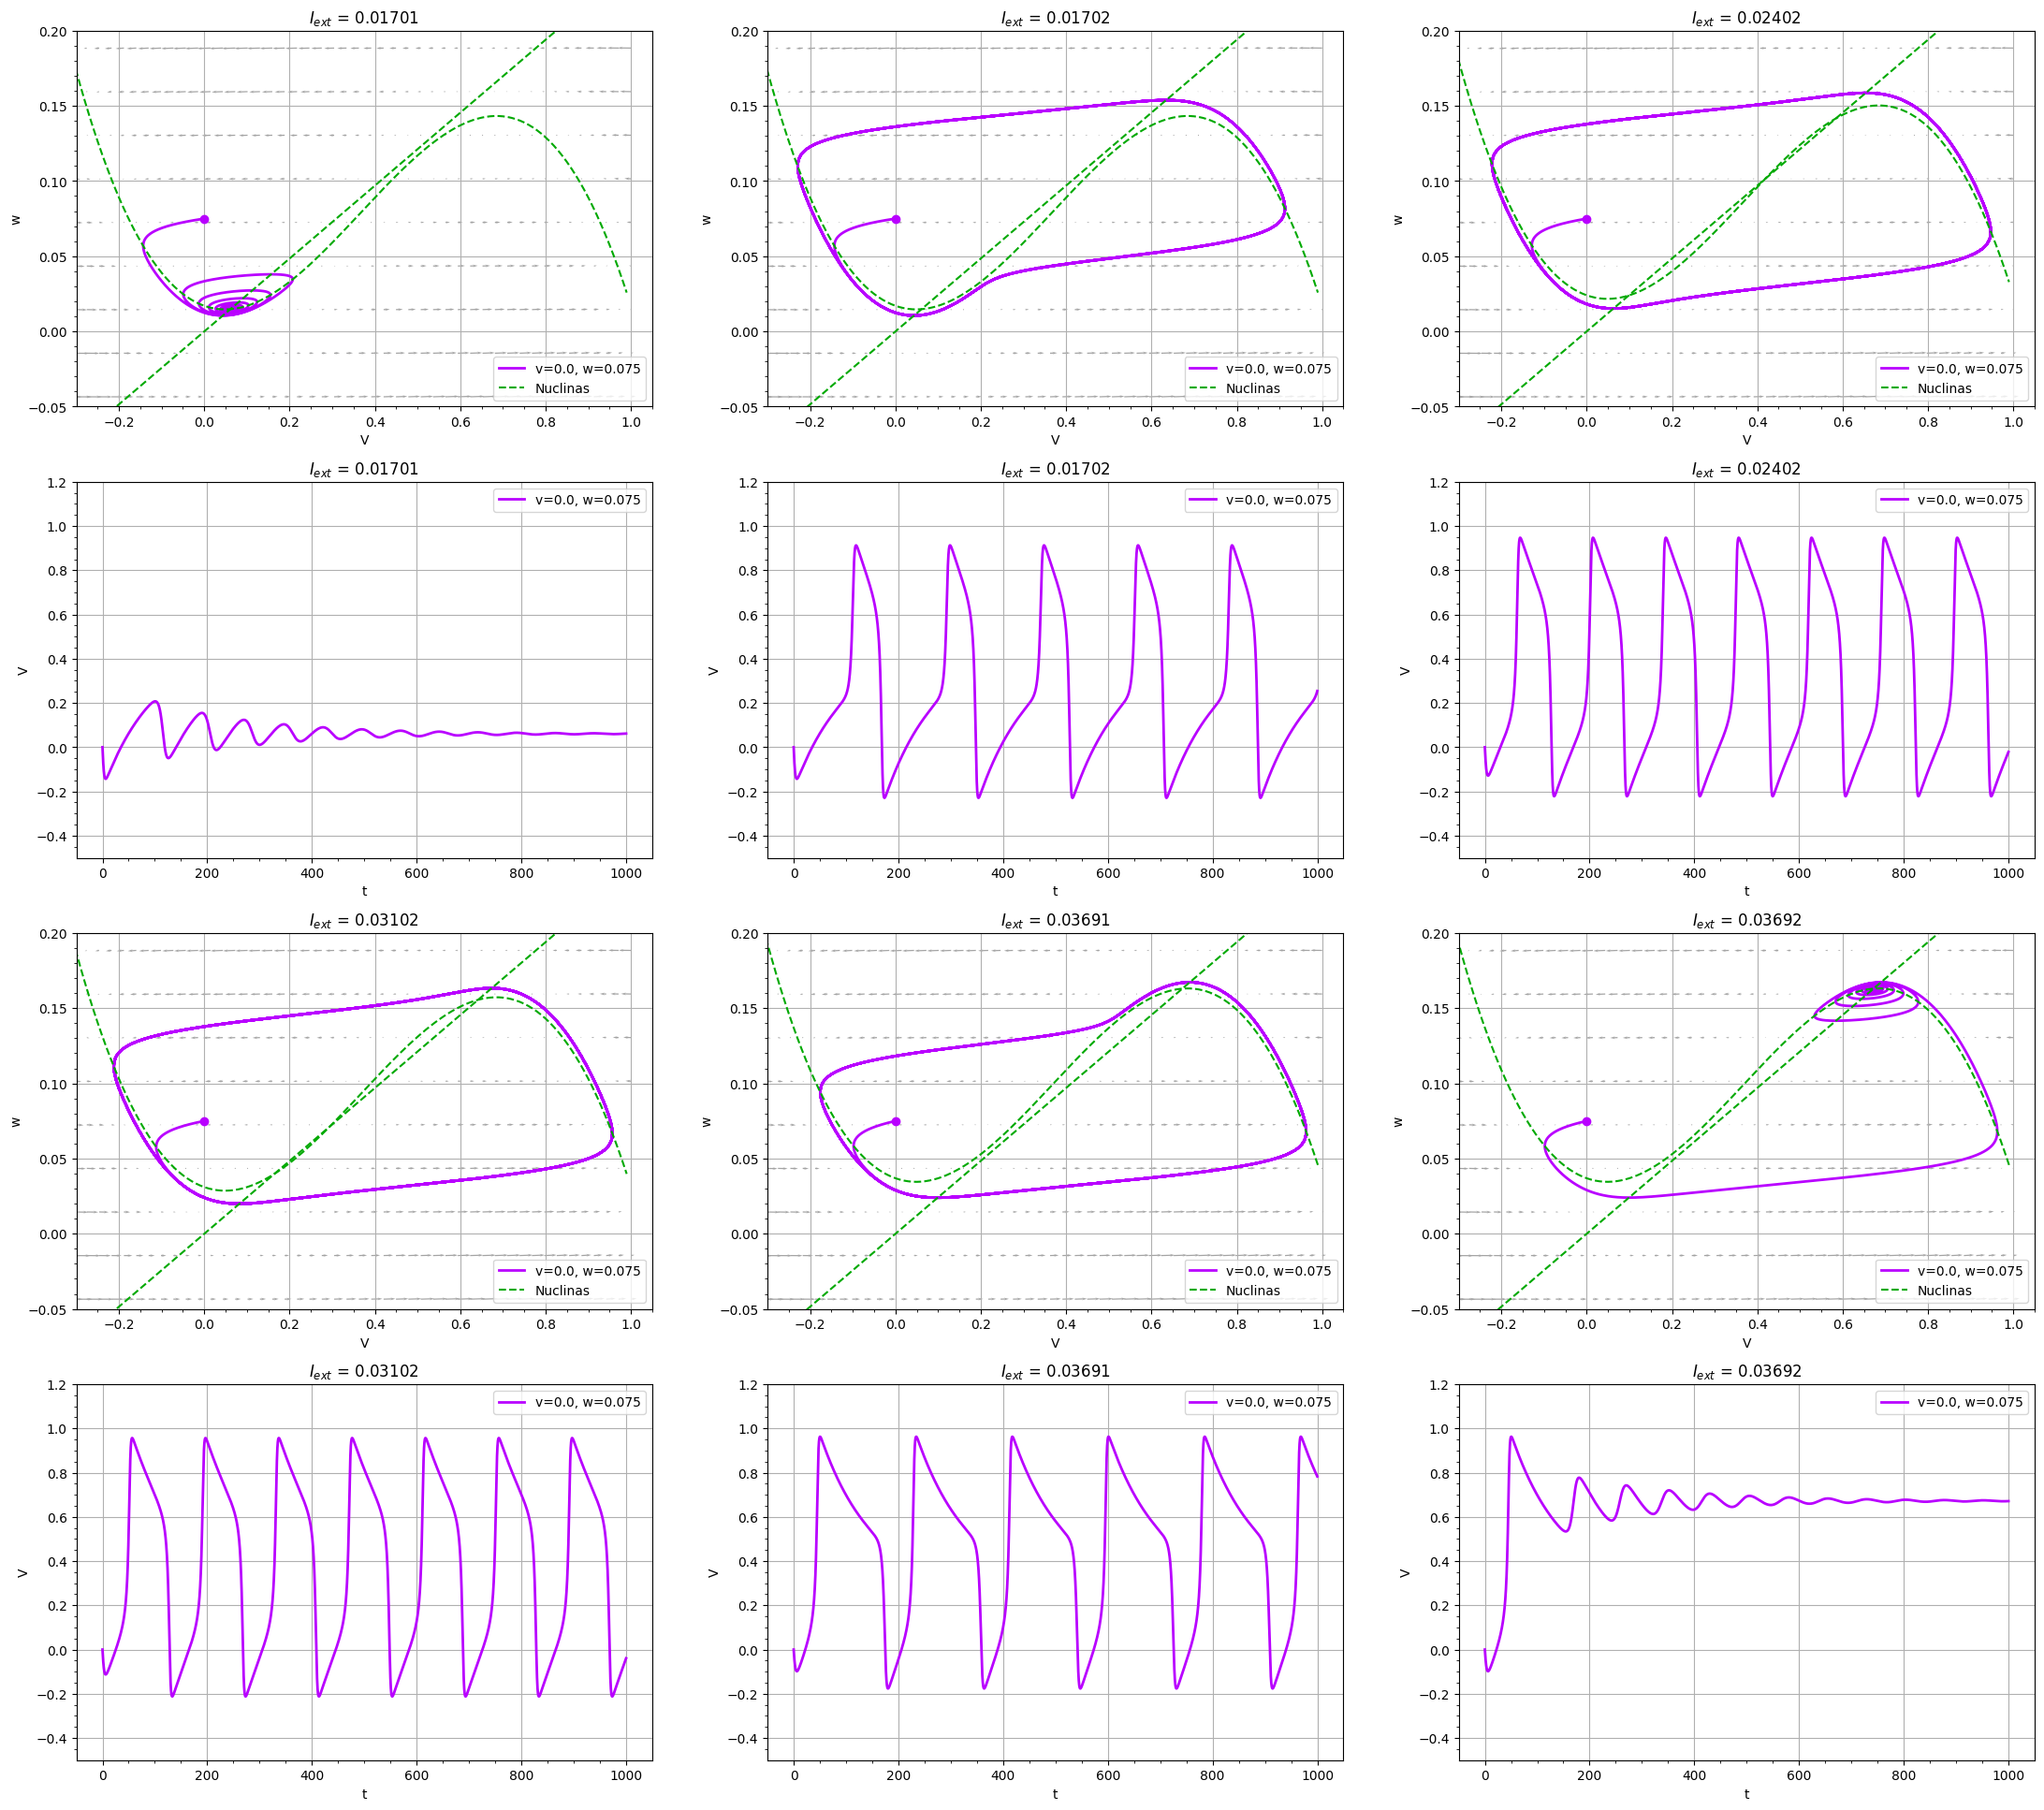

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(27, 24))

#trayectoria y punto inicial
ax[0,0].plot(y_tray1_model4[:,0], y_tray1_model4[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,0].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[0,0].quiver(x4, y4, dx4, dy4, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[0,0].plot(x_nullcline, y_nullcline1_model4, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[0,0].plot(x_nullcline, y_nullcline2_model4, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#maquillamos la gráfica
ax[0,0].set_title(r'$I_{ext}$ = ' + str(modelo4.get_iext()))
ax[0,0].set_xlim(-0.3, 1.05)
ax[0,0].set_ylim(-0.05, 0.2)
ax[0,0].set_xlabel('V')
ax[0,0].set_ylabel('w')
ax[0,0].legend(fontsize=10)
ax[0,0].grid()
ax[0,0].minorticks_on()


#trayectoria y punto inicial
ax[0,1].plot(y_tray1_model5[:,0], y_tray1_model5[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,1].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[0,1].quiver(x5, y5, dx5, dy5, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[0,1].plot(x_nullcline, y_nullcline1_model5, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[0,1].plot(x_nullcline, y_nullcline2_model5, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos bonita
ax[0,1].set_title(r'$I_{ext}$ = ' + str(modelo5.get_iext()))
ax[0,1].set_xlim(-0.3, 1.05)
ax[0,1].set_ylim(-0.05, 0.2)
ax[0,1].set_xlabel('V')
ax[0,1].set_ylabel('w')
ax[0,1].legend(fontsize=10)
ax[0,1].grid()
ax[0,1].minorticks_on()


#trayectoria y punto inicial
ax[0,2].plot(y_tray1_model6[:,0], y_tray1_model6[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[0,2].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[0,2].quiver(x6, y6, dx6, dy6, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[0,2].plot(x_nullcline, y_nullcline1_model6, color=colores[4],
             linestyle='dashed', linewidth=1.5)
ax[0,2].plot(x_nullcline, y_nullcline2_model6, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos linda
ax[0,2].set_title(r'$I_{ext}$ = ' + str(modelo6.get_iext()))
ax[0,2].set_xlim(-0.3, 1.05)
ax[0,2].set_ylim(-0.05, 0.2)
ax[0,2].set_xlabel('V')
ax[0,2].set_ylabel('w')
ax[0,2].legend(fontsize=10)
ax[0,2].grid()
ax[0,2].minorticks_on()

#trayectoria v-t
ax[1,0].plot(x_tray1_model4, y_tray1_model4[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#maquillamos
ax[1,0].set_title(r'$I_{ext}$ = ' + str(modelo4.get_iext()))
ax[1,0].set_ylim(-0.5, 1.2)
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('V')
ax[1,0].legend(fontsize=10)
ax[1,0].grid()
ax[1,0].minorticks_on()


#trayectoria v-t
ax[1,1].plot(x_tray1_model5, y_tray1_model5[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#ponemos bonita
ax[1,1].set_title(r'$I_{ext}$ = ' + str(modelo5.get_iext()))
ax[1,1].set_ylim(-0.5, 1.2)
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('V')
ax[1,1].legend(fontsize=10)
ax[1,1].grid()
ax[1,1].minorticks_on()


#trayectoria v-t
ax[1,2].plot(x_tray1_model6, y_tray1_model6[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#ponemos linda
ax[1,2].set_title(r'$I_{ext}$ = ' + str(modelo6.get_iext()))
ax[1,2].set_ylim(-0.5, 1.2)
ax[1,2].set_xlabel('t')
ax[1,2].set_ylabel('V')
ax[1,2].legend(fontsize=10)
ax[1,2].grid()
ax[1,2].minorticks_on()


#trayectoria y punto inicial
ax[2,0].plot(y_tray1_model7[:,0], y_tray1_model7[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[2,0].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[2,0].quiver(x7, y7, dx7, dy7, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[2,0].plot(x_nullcline, y_nullcline1_model7, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[2,0].plot(x_nullcline, y_nullcline2_model7, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#maquillamos
ax[2,0].set_title(r'$I_{ext}$ = ' + str(modelo7.get_iext()))
ax[2,0].set_xlim(-0.3, 1.05)
ax[2,0].set_ylim(-0.05, 0.2)
ax[2,0].set_xlabel('V')
ax[2,0].set_ylabel('w')
ax[2,0].legend(fontsize=10)
ax[2,0].grid()
ax[2,0].minorticks_on()

#trayectoria y punto inicial
ax[2,1].plot(y_tray1_model8[:,0], y_tray1_model8[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[2,1].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[2,1].quiver(x8, y8, dx8, dy8, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[2,1].plot(x_nullcline, y_nullcline1_model8, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[2,1].plot(x_nullcline, y_nullcline2_model8, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos bonita
ax[2,1].set_title(r'$I_{ext}$ = ' + str(modelo8.get_iext()))
ax[2,1].set_xlim(-0.3, 1.05)
ax[2,1].set_ylim(-0.05, 0.2)
ax[2,1].set_xlabel('V')
ax[2,1].set_ylabel('w')
ax[2,1].legend(fontsize=10)
ax[2,1].grid()
ax[2,1].minorticks_on()


#trayectoria y punto inicial
ax[2,2].plot(y_tray1_model9[:,0], y_tray1_model9[:,1],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])
ax[2,2].plot(y_ini1[0], y_ini1[1], markersize=6, marker='o', color=colores[9])

#campo vectorial
ax[2,2].quiver(x9, y9, dx9, dy9, color=colores[14], scale=7.5, width=0.002,
               headwidth=2.5, headlength=4.5, headaxislength = 3)

#nulclinas
ax[2,2].plot(x_nullcline, y_nullcline1_model9, color=colores[4],
             linestyle='dashed', linewidth=1.5)

ax[2,2].plot(x_nullcline, y_nullcline2_model9, color=colores[4],
             linestyle='dashed', linewidth=1.5, label='Nuclinas')

#ponemos linda
ax[2,2].set_title(r'$I_{ext}$ = ' + str(modelo9.get_iext()))
ax[2,2].set_xlim(-0.3, 1.05)
ax[2,2].set_ylim(-0.05, 0.2)
ax[2,2].set_xlabel('V')
ax[2,2].set_ylabel('w')
ax[2,2].legend(fontsize=10)
ax[2,2].grid()
ax[2,2].minorticks_on()

#trayectoria v-t
ax[3,0].plot(x_tray1_model7, y_tray1_model7[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#maquillamos
ax[3,0].set_title(r'$I_{ext}$ = ' + str(modelo7.get_iext()))
ax[3,0].set_ylim(-0.5, 1.2)
ax[3,0].set_xlabel('t')
ax[3,0].set_ylabel('V')
ax[3,0].legend(fontsize=10)
ax[3,0].grid()
ax[3,0].minorticks_on()


#trayectoria v-t
ax[3,1].plot(x_tray1_model8, y_tray1_model8[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#ponemos bonita
ax[3,1].set_title(r'$I_{ext}$ = ' + str(modelo8.get_iext()))
ax[3,1].set_ylim(-0.5, 1.2)
ax[3,1].set_xlabel('t')
ax[3,1].set_ylabel('V')
ax[3,1].legend(fontsize=10)
ax[3,1].grid()
ax[3,1].minorticks_on()


#trayectoria v-t
ax[3,2].plot(x_tray1_model9, y_tray1_model9[:,0],
             label="v=" + str(y_ini1[0]) + ", w=" + str(y_ini1[1]),
             linewidth=2, color=colores[9])

#ponemos linda
ax[3,2].set_title(r'$I_{ext}$ = ' + str(modelo9.get_iext()))
ax[3,2].set_ylim(-0.5, 1.2)
ax[3,2].set_xlabel('t')
ax[3,2].set_ylabel('V')
ax[3,2].legend(fontsize=10)
ax[3,2].grid()
ax[3,2].minorticks_on()

plt.show()

Ahora definimos una función para graficar diagramas de bifurcación a partir de la ecuación del mapa

In [ ]:
def graphbif(map, x0, xf, y0, yf, xlab, ylab):
  rvals = np.linspace(0, 2.1, 1400) #parámetros a estudiar
  num_iterations = 1000
  x = -1e-5 + np.zeros(len(rvals)) #punto inicial
  for i in range(num_iterations):
      x = map(rvals, -x)

      # Plotear solo las últimas iteraciones
      if i >= num_iterations - 100:
          plt.plot(rvals, x, ',r', alpha=.25)

  # Configurar el gráfico
  plt.xlim(x0, xf)
  plt.ylim(y0, yf)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.grid()
  plt.minorticks_on()
  return

Definimos el mapa a graficar

In [ ]:
def qubicmap(r, x):
    return r*x - x**3

Y a hacer magia

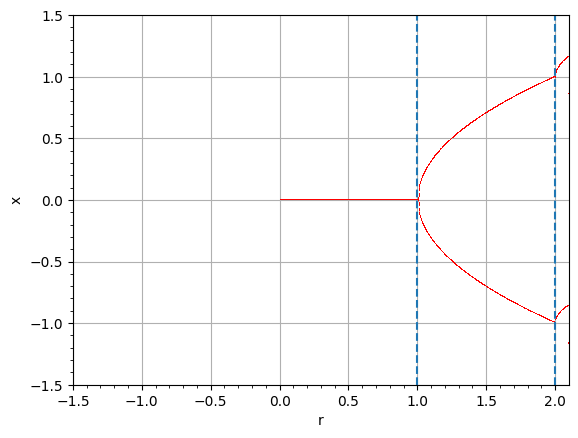

In [ ]:
graphbif(qubicmap, -1.5, 2.1, -1.5, 1.5, 'r', 'x')
plt.axvline(x = 1, linestyle='dashed')
plt.axvline(x = 2, linestyle='dashed')
plt.show()